<a href="https://colab.research.google.com/github/WENDELLDELIMA/Mestrado_Mackenzie_Aprendizado_Maquina_MLP_IBOVESPA/blob/main/Mackenzie_aprendizado_de_maquina_ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das Libs



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Carregando CSV

In [ ]:
df = pd.read_csv("ibovespa.csv")

# Criar datas (última = hoje)

In [ ]:

df['data'] = pd.date_range(end=pd.Timestamp.today().normalize(),
                           periods=len(df), freq='B')

df = df[['data', 'ibovespa']]
df.set_index('data', inplace=True)

# Normalizando valores indo de 0 a 1

In [ ]:
series = df[['ibovespa']].values

scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)

print('valores normalizados', series_scaled)




valores normalizados [[0.01644165]
 [0.01663473]
 [0.01659018]
 ...
 [0.9854149 ]
 [0.99462342]
 [1.        ]]


# Separar treino e teste (20 dias finais ficam de fora)

In [ ]:

train_scaled = series_scaled[:-20]
test_scaled  = series_scaled[-20:]

# Criando função de sequencia para aprender a prever a saida do proximo dia

In [ ]:
def create_sequences(data, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size].flatten())
        y.append(data[i+window_size])
    return np.array(X), np.array(y).ravel()

window_size = 10
X_train, y_train = create_sequences(train_scaled, window_size)


# Criando Modelo de Rede Neural

In [ ]:
mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # duas camadas (100 e 50 neurônios)
    activation='tanh',             # ativação mais adequada a dados normalizados
    solver='adam',
    alpha=0.001,                   # regularização
    max_iter=500,                  # mais iterações
    early_stopping=True,           # para sozinho se não melhorar
    random_state=42
)



history = mlp.fit(X_train, y_train)


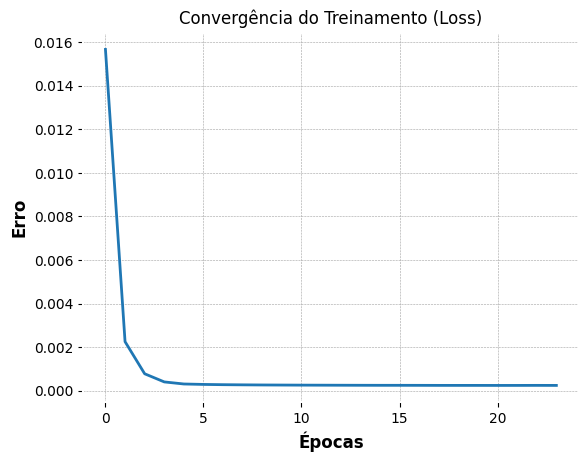

In [ ]:
plt.plot(mlp.loss_curve_)
plt.title("Convergência do Treinamento (Loss)")
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.grid(True)
plt.show()


# Deslocamento de Janela

In [ ]:
last_window = train_scaled[-window_size:].flatten()
preds_rec_scaled = []

for _ in range(20):
    pred = mlp.predict(last_window.reshape(1, -1))[0]
    preds_rec_scaled.append(pred)
    last_window = np.append(last_window[1:], pred)




# Voltando valores normalizados para escala original

In [ ]:

preds_rec = scaler.inverse_transform(np.array(preds_rec_scaled).reshape(-1,1)).flatten()
real_values = df['ibovespa'][-20:].values

# Grafico do Resultado

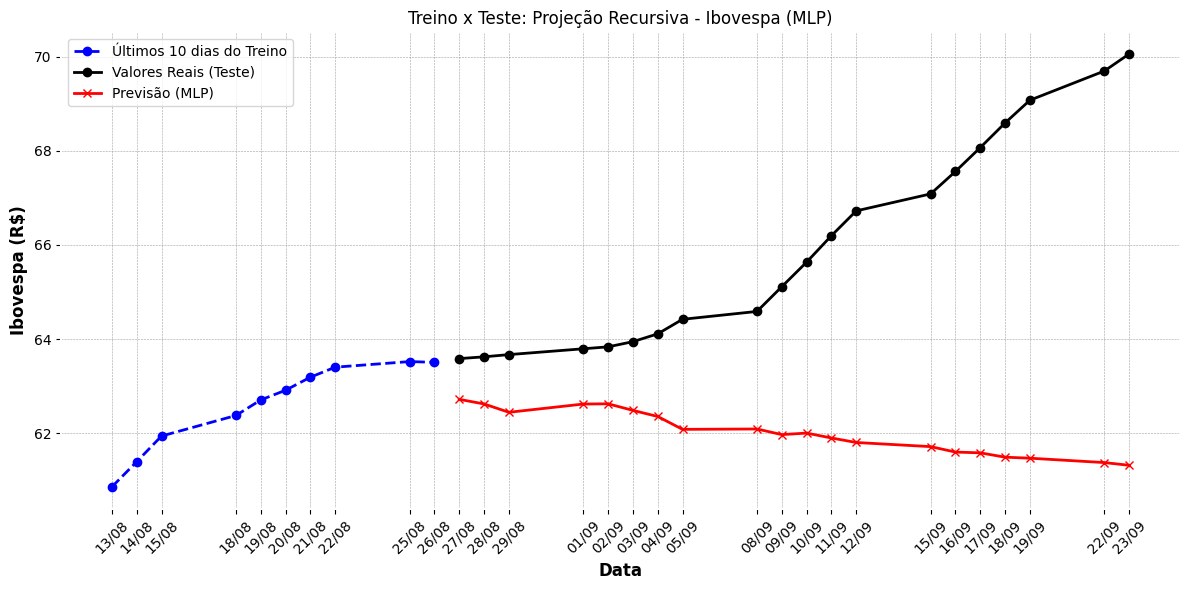

In [ ]:
import matplotlib.dates as mdates

plt.figure(figsize=(12,6))

# Eixo contínuo só de dias úteis entre o início dos 30 dias e o final dos 20 dias
full_index = pd.date_range(start=df.index[-30], end=df.index[-1], freq='B')

# Últimos 10 dias do treino (azul tracejado)
plt.plot(df.index[-30:-20], df['ibovespa'].values[-30:-20],
         marker='o', color="blue", linestyle='--', label="Últimos 10 dias do Treino")

# Valores reais do teste (preto)
plt.plot(df.index[-20:], real_values, marker='o', color="black", label="Valores Reais (Teste)")

# Previsões recursivas (vermelho)
plt.plot(df.index[-20:], preds_rec, marker='x', color="red", label="Previsão (MLP)")

plt.title("Treino x Teste: Projeção Recursiva - Ibovespa (MLP)")
plt.xlabel("Data")
plt.ylabel("Ibovespa (R$)")
plt.legend()
plt.grid(True)

ax = plt.gca()
ax.set_xticks(full_index)  # força todos os dias úteis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



*Curva de Perdas*

# Erros

In [ ]:
mae_rec = mean_absolute_error(real_values, preds_rec)
rmse_rec = np.sqrt(mean_squared_error(real_values, preds_rec))

print("Erro Recursivo (multi-step):")
print("MAE:", round(mae_rec,2))
print("RMSE:", round(rmse_rec,2))

Erro Recursivo (multi-step):
MAE: 3.95
RMSE: 4.74


“Para avaliar o desempenho do modelo recursivo, calculamos duas métricas de erro:

MAE (Erro Médio Absoluto): indica em média quanto a previsão se afastou dos valores reais do Ibovespa.

RMSE (Raiz do Erro Quadrático Médio): penaliza mais os erros grandes, mostrando a gravidade das divergências.

Quanto menores esses valores, melhor o modelo. No entanto, como os erros da previsão recursiva se acumulam, o MAE e o RMSE tendem a ser maiores. *texto em itálico*

In [ ]:


# Valores em REAIS
ultimo_treino = df['ibovespa'].values[-21]         # último dia do treino (dia imediatamente antes do teste)
media_ultimos10 = df['ibovespa'].values[-30:-20].mean()
primeiro_real = df['ibovespa'].values[-20]
pred1 = preds_rec[0]                                # primeiro previsto da recursiva

# 1) Primeiro passo: subiu ou desceu?
delta_primeiro = pred1 - ultimo_treino

# 2) Média dos incrementos previstos (20 dias)
inc_prev = np.diff(preds_rec)                       # pred[i] - pred[i-1]
media_inc_prev = inc_prev.mean()

# (referência) Média dos incrementos reais no teste
inc_real = np.diff(df['ibovespa'].values[-20:])
media_inc_real = inc_real.mean()

# 3) Puxa para a média? (quem está mais perto do pred1: média dos 10 do treino ou o real do 1º dia?)
dist_pred_media10 = abs(pred1 - media_ultimos10)
dist_pred_real1   = abs(pred1 - primeiro_real)

print("1) Primeiro passo (pred1 - último do treino):", round(delta_primeiro, 4))
print("   -> Negativo? {} (começou descendo)".format(delta_primeiro < 0))

print("\n2) Média dos incrementos das previsões (pred[i]-pred[i-1]):", round(media_inc_prev, 4))
print("   Média dos incrementos reais do teste:", round(media_inc_real, 4))
print("   -> Previsões descem em média? {} ".format(media_inc_prev < 0))

print("\n3) Distância do 1º previsto:")
print("   Até a MÉDIA dos 10 do treino:", round(dist_pred_media10, 4))
print("   Até o 1º REAL do teste:", round(dist_pred_real1, 4))
print("   -> Puxou para a média do treino? {}".format(dist_pred_media10 < dist_pred_real1))


1) Primeiro passo (pred1 - último do treino): -0.7865
   -> Negativo? True (começou descendo)

2) Média dos incrementos das previsões (pred[i]-pred[i-1]): -0.0737
   Média dos incrementos reais do teste: 0.3406
   -> Previsões descem em média? True 

3) Distância do 1º previsto:
   Até a MÉDIA dos 10 do treino: 0.1382
   Até o 1º REAL do teste: 0.8655
   -> Puxou para a média do treino? True


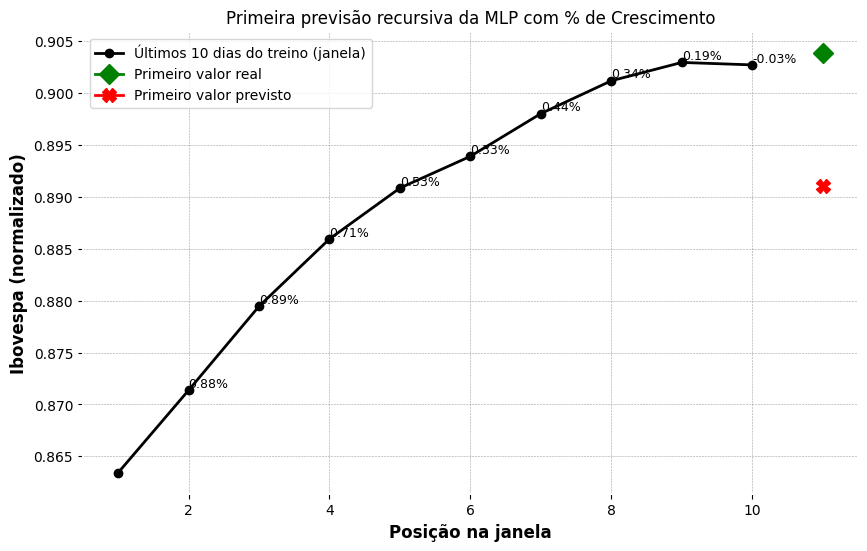

In [ ]:
import pandas as pd
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib.pyplot

# Últimos 10 dias do treino (janela usada na previsão) - normalized values
x_values = range(1, 11)
y_values = train_scaled[-10:].flatten() # Ensure y_values is 1D

# Create the second plot with percentage changes annotated
plt.figure(figsize=(10,6))

plt.plot(x_values, y_values, marker='o', label="Últimos 10 dias do treino (janela)", color="black")

# Primeiro valor real do teste - normalized
plt.plot(11, test_scaled[0], marker='D', markersize=10, color="green", label="Primeiro valor real")

# Primeiro valor previsto - normalized
plt.plot(11, preds_rec_scaled[0], marker='X', markersize=10, color="red", label="Primeiro valor previsto")

# Calculate percentage changes for the last 10 training days
# Need the actual (non-normalized) values for correct percentage calculation
train_real_last10 = df['ibovespa'].iloc[-30:-20].values
percentage_changes_train = pd.Series(train_real_last10).pct_change() * 100


# Annotate percentage changes on the black line
for i in range(1, len(x_values)):
    if not np.isnan(percentage_changes_train.iloc[i]):
        plt.text(x_values[i], y_values[i], f'{percentage_changes_train.iloc[i]:.2f}%', fontsize=9, ha='left', va='bottom')


plt.title("Primeira previsão recursiva da MLP com % de Crescimento")
plt.xlabel("Posição na janela")
plt.ylabel("Ibovespa (normalizado)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def previsao_recursiva(df, mlp, scaler, window_size=10, start_idx=None, steps=20):
    """
    Faz previsão recursiva a partir de uma janela escolhida.

    df          : dataframe com os valores originais
    mlp         : modelo treinado (já ajustado no fit)
    scaler      : scaler usado no pré-processamento
    window_size : tamanho da janela (default = 10)
    start_idx   : índice inicial da janela (se None, usa a última)
    steps       : número de passos a prever
    """

    data_scaled = scaler.transform(df[['ibovespa']])

    # Se não passar índice, usa a última janela
    if start_idx is None:
        last_window = data_scaled[-window_size:].flatten()
        janela_datas = df.index[-window_size:]
    else:
        last_window = data_scaled[start_idx:start_idx+window_size].flatten()
        janela_datas = df.index[start_idx:start_idx+window_size]

    preds_scaled = []
    for _ in range(steps):
        pred = mlp.predict(last_window.reshape(1, -1))[0]
        preds_scaled.append(pred)
        last_window = np.append(last_window[1:], pred)

    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()

    return janela_datas, preds


In [ ]:
janela, preds_default = previsao_recursiva(df, mlp, scaler, window_size=10, steps=20)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


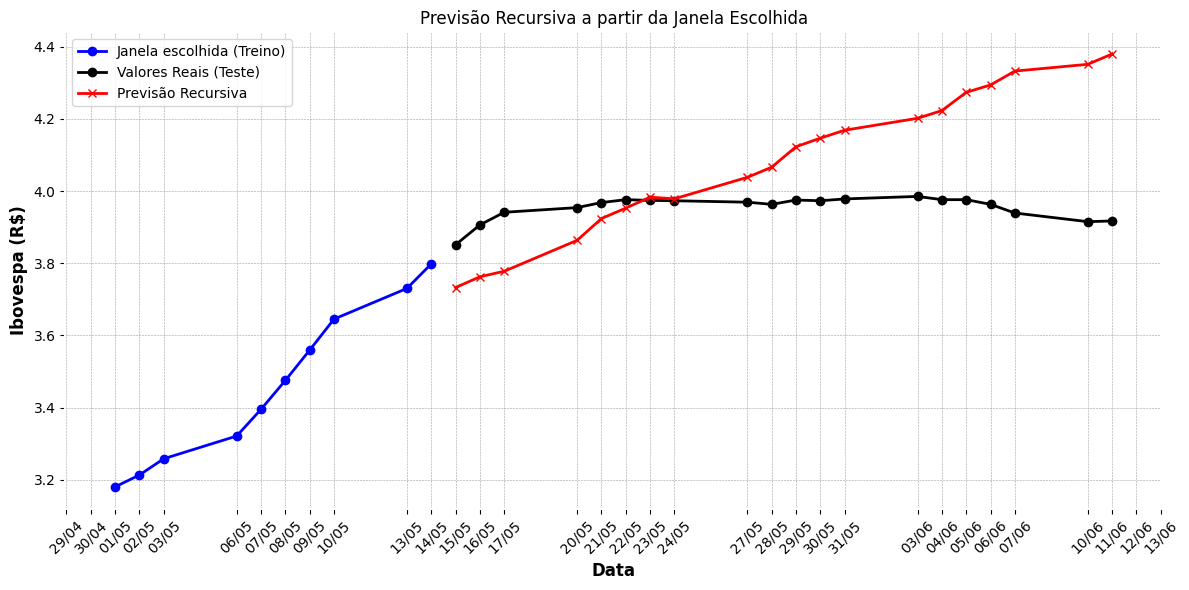

In [ ]:
import matplotlib.dates as mdates

# Função para previsão recursiva com janela escolhida
def previsao_recursiva(df, mlp, scaler, window_size=10, start_idx=None, steps=20):
    data_scaled = scaler.transform(df[['ibovespa']])

    # Se não passar índice, usa a última janela
    if start_idx is None:
        last_window = data_scaled[-window_size:].flatten()
        janela_datas = df.index[-window_size:]
        future_index = df.index[-steps:]  # últimos 20 dias como teste
    else:
        last_window = data_scaled[start_idx:start_idx+window_size].flatten()
        janela_datas = df.index[start_idx:start_idx+window_size]
        future_index = df.index[start_idx+window_size:start_idx+window_size+steps]

    preds_scaled = []
    for _ in range(steps):
        pred = mlp.predict(last_window.reshape(1, -1))[0]
        preds_scaled.append(pred)
        last_window = np.append(last_window[1:], pred)

    preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()

    return janela_datas, future_index, preds


# Exemplo de uso
janela, future_index, preds_default = previsao_recursiva(df, mlp, scaler, window_size=10, start_idx=50, steps=20)

# Plotando
plt.figure(figsize=(12,6))

# Janela escolhida
plt.plot(janela, df.loc[janela, 'ibovespa'], marker='o', color="blue", label="Janela escolhida (Treino)")

# Valores reais futuros (se existirem)
plt.plot(future_index, df.loc[future_index, 'ibovespa'], marker='o', color="black", label="Valores Reais (Teste)")

# Previsões
plt.plot(future_index, preds_default, marker='x', color="red", label="Previsão Recursiva")

plt.title("Previsão Recursiva a partir da Janela Escolhida")
plt.xlabel("Data")
plt.ylabel("Ibovespa (R$)")
plt.legend()
plt.grid(True)

# 📌 Forçar mostrar apenas dias úteis no eixo X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=[0,1,2,3,4]))  # apenas seg-sex
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


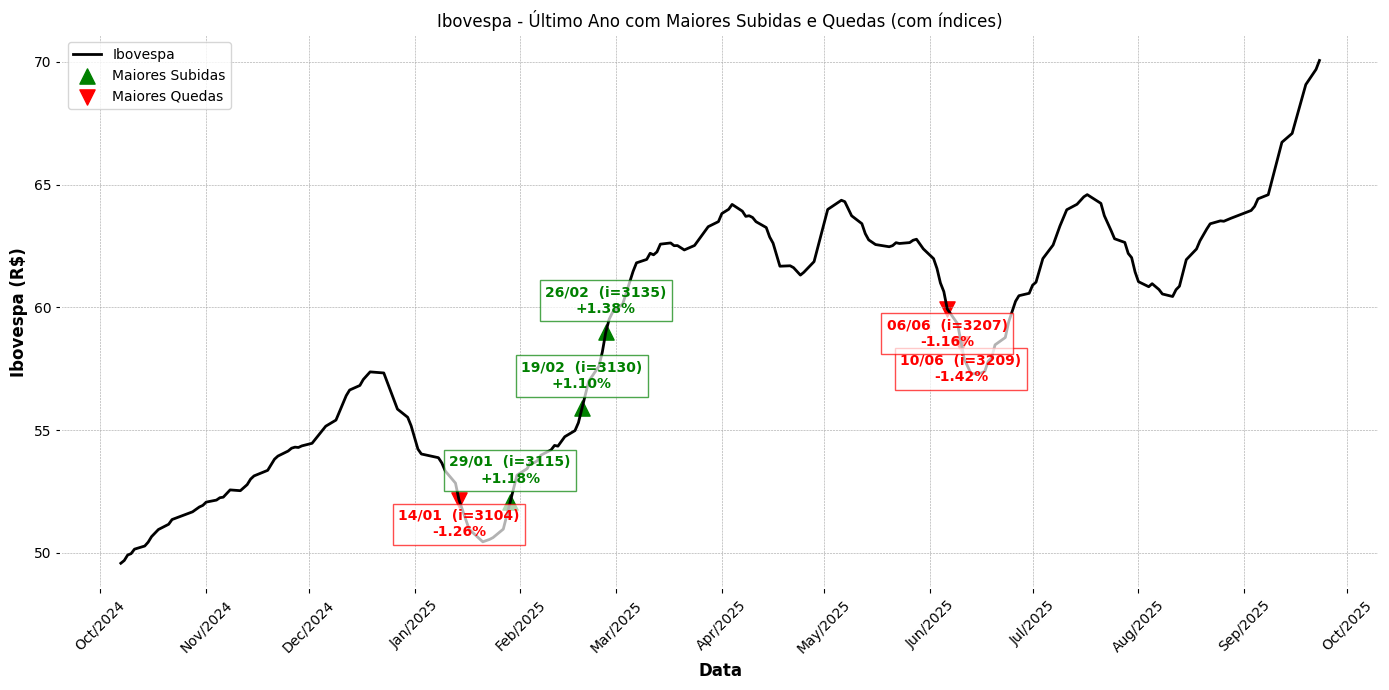

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(ultimo_ano.index, ultimo_ano['ibovespa'], color="black", label="Ibovespa")

# Subidas (verde)
plt.scatter(top_subidas.index, top_subidas['ibovespa'], color="green", s=120, marker='^', label="Maiores Subidas")
for idx, row in top_subidas.iterrows():
    i_global = df.index.get_loc(idx)
    plt.text(idx, row['ibovespa']+0.8,
             f"{idx.strftime('%d/%m')}  (i={i_global})\n+{row['var_pct']:.2f}%",
             color="green", fontsize=10, ha='center', weight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='green'))

# Quedas (vermelho)
plt.scatter(top_quedas.index, top_quedas['ibovespa'], color="red", s=120, marker='v', label="Maiores Quedas")
for idx, row in top_quedas.iterrows():
    i_global = df.index.get_loc(idx)
    plt.text(idx, row['ibovespa']-1.5,
             f"{idx.strftime('%d/%m')}  (i={i_global})\n{row['var_pct']:.2f}%",
             color="red", fontsize=10, ha='center', weight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'))

# Configuração do gráfico
plt.title("Ibovespa - Último Ano com Maiores Subidas e Quedas (com índices)")
plt.xlabel("Data")
plt.ylabel("Ibovespa (R$)")
plt.legend()
plt.grid(True)

# Mostrar meses no eixo X
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Criar tabelas auxiliares
subidas_table = top_subidas.copy()
subidas_table["Tipo"] = "Subida"
subidas_table["Indice"] = [df.index.get_loc(idx) for idx in top_subidas.index]

quedas_table = top_quedas.copy()
quedas_table["Tipo"] = "Queda"
quedas_table["Indice"] = [df.index.get_loc(idx) for idx in top_quedas.index]

# Juntar
tabela_eventos = pd.concat([subidas_table, quedas_table]).sort_index()
tabela_eventos = tabela_eventos[["Indice", "ibovespa", "var_pct", "Tipo"]]
tabela_eventos.index.name = "Data"

# Renomear colunas
tabela_eventos = tabela_eventos.rename(columns={
    "ibovespa": "Ibovespa (R$)",
    "var_pct": "Variação (%)"
})

# Mostrar tabela
import tabulate
print(tabulate.tabulate(tabela_eventos.reset_index(), headers="keys", tablefmt="psql", showindex=False))


+---------------------+----------+-----------------+----------------+--------+
| Data                |   Indice |   Ibovespa (R$) |   Variação (%) | Tipo   |
|---------------------+----------+-----------------+----------------+--------|
| 2025-01-14 00:00:00 |     3104 |          52.17  |       -1.26237 | Queda  |
| 2025-01-29 00:00:00 |     3115 |          52.056 |        1.17981 | Subida |
| 2025-02-19 00:00:00 |     3130 |          55.908 |        1.09763 | Subida |
| 2025-02-26 00:00:00 |     3135 |          58.979 |        1.37507 | Subida |
| 2025-06-06 00:00:00 |     3207 |          59.934 |       -1.16425 | Queda  |
| 2025-06-10 00:00:00 |     3209 |          58.491 |       -1.42243 | Queda  |
+---------------------+----------+-----------------+----------------+--------+


In [ ]:
# Função para rodar previsão e plotar a partir de um índice escolhido
def testar_indice(df, mlp, scaler, start_idx, window_size=10, steps=20):
    janela, future_index, preds = previsao_recursiva(
        df, mlp, scaler, window_size=window_size, start_idx=start_idx, steps=steps
    )

    plt.figure(figsize=(12,6))

    # Janela de treino
    plt.plot(janela, df.loc[janela, 'ibovespa'], marker='o', color="blue", label="Janela (Treino)")

    # Valores reais futuros (se existirem)
    if len(future_index) > 0:
        plt.plot(future_index, df.loc[future_index, 'ibovespa'], marker='o', color="black", label="Valores Reais (Teste)")

    # Previsões
    plt.plot(future_index, preds, marker='x', color="red", label="Previsão Recursiva")

    plt.title(f"Previsão Recursiva iniciada no índice {start_idx} ({df.index[start_idx].strftime('%d/%m/%Y')})")
    plt.xlabel("Data")
    plt.ylabel("Ibovespa (R$)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


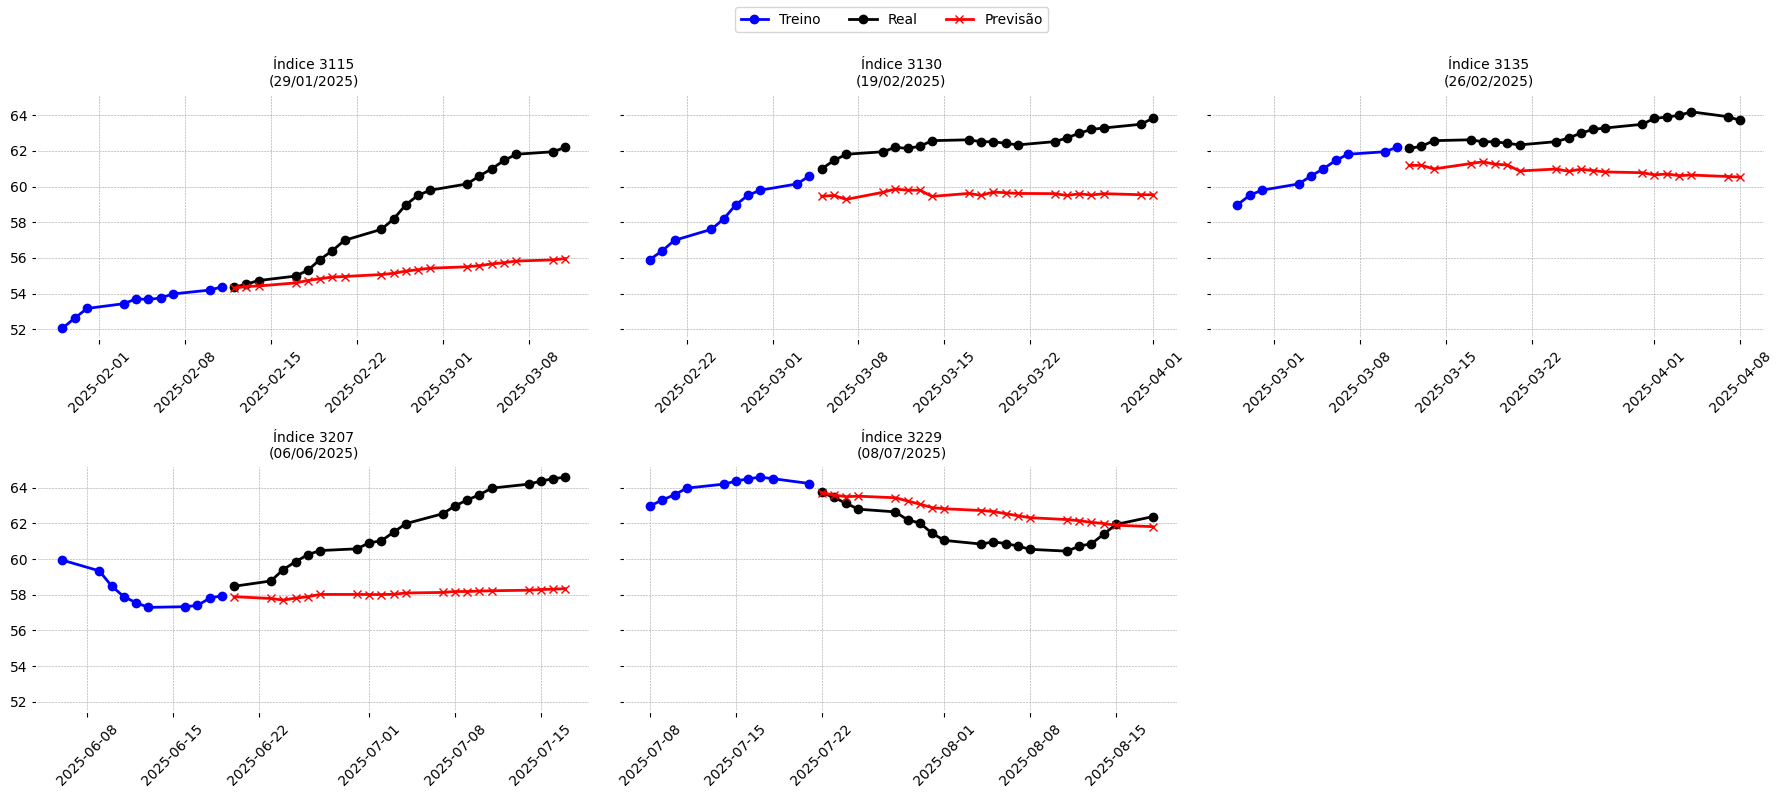

In [ ]:
import matplotlib.pyplot as plt

# Lista dos índices das maiores subidas e quedas
indices_teste = [3115, 3130, 3135, 3207, 3229]

# Criar subplots (2 linhas x 3 colunas)
fig, axes = plt.subplots(2, 3, figsize=(18,8), sharey=True)

# Transformar axes em array 1D para iterar facilmente
axes = axes.flatten()

for i, idx in enumerate(indices_teste):
    ax = axes[i]

    # Rodar previsão para o índice
    janela, future_index, preds = previsao_recursiva(df, mlp, scaler, window_size=10, start_idx=idx, steps=20)

    # Plotar no subplot
    ax.plot(janela, df.loc[janela, 'ibovespa'], marker='o', color="blue", label="Treino")
    ax.plot(future_index, df.loc[future_index, 'ibovespa'], marker='o', color="black", label="Real")
    ax.plot(future_index, preds, marker='x', color="red", label="Previsão")

    # Título com índice e data
    ax.set_title(f"Índice {idx}\n({df.index[idx].strftime('%d/%m/%Y')})", fontsize=10)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)

# Remover o último subplot vazio se tiver
if len(indices_teste) < len(axes):
    for j in range(len(indices_teste), len(axes)):
        fig.delaxes(axes[j])

# Legenda única no topo
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=10)

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
